This notebook walks through the core functionality of the package. 

# Basics and OLS

To begin, let's load the Longly dataset from Statsmodels. Statjax follows the Scikit-Learn convention of `model().fit(X,y)` rather than the Statsmodels convention of `model(y,X).fit()`. Models can take dataframe, array, or model matrix (see below) inputs. They will add intercepts unless `add_intercept = False` is passed in fit. 


In [1]:
import statsmodels.api as sm
import statjax as sj


longley = sm.datasets.longley.load_pandas()
X = longley.exog
y = longley.endog

ols= sj.OLS().fit(X, y)
ols_no_intercept= sj.OLS().fit(X, y, add_intercept=False)

The OLS model supports non-robust, heteroskedasticity-robust, and clustered standard errors following [Cameron and Miller (2015)](https://cameron.econ.ucdavis.edu/research/Cameron_Miller_JHR_2015_February.pdf).

In [2]:
ols_robust = sj.OLS("robust").fit(X,y,)
decade = X["YEAR"] // 10
ols_clustered = sj.OLS("clustered").fit(X, y, decade)

To visualize, use the table functionality, which closely follows the Python Stargazer package – see their documentation for table options. 

In [3]:
ols_table = sj.RegressionTable([ols , ols_robust, ols_clustered])
ols_table.custom_columns(["OLS", "OLS (robust)", "OLS (clustered)"])
ols_table.title("OLS regressions")
display(ols_table)

The tables can be converted to latex for display, which additionally cleans up the dependent variable row - see demo_table.pdf.

In [4]:
print(ols_table.render_latex())

\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\textit{Dependent variable: } &  \multicolumn{3}{c}{TOTEMP} 
% \\[-1.8ex]
\cr \cline{2-4}
\\[-1.8ex]\\[-1.8ex] & \multicolumn{1}{c}{OLS} & \multicolumn{1}{c}{OLS (robust)} & \multicolumn{1}{c}{OLS (clustered)}  \\
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 Intercept & -3482258.637$^{***}$ & -3482258.637$^{***}$ & -3482258.637$^{***}$ \\
& (4.69e-03) & (6.08e-03) & (1.38e-03) \\
 GNPDEFL & 15.062$^{}$ & 15.062$^{}$ & 15.062$^{}$ \\
& (83.113) & (87.551) & (45.657) \\
 GNP & -0.036$^{*}$ & -0.036$^{}$ & -0.036$^{***}$ \\
& (0.019) & (0.022) & (6.48e-03) \\
 UNEMP & -2.020$^{***}$ & -2.020$^{***}$ & -2.020$^{***}$ \\
& (0.268) & (0.300) & (0.073) \\
 ARMED & -1.033$^{***}$ & -1.033$^{***}$ & -1.033$^{***}$ \\
& (0.179) & (0.110) & (0.063) \\
 POP & -0.051$^{}$ & -0.051$^{}$ & -0.051$^{}$ \\
& (0.206) & (0.261) & (0.057) \\
 YEAR & 1829.151$^{***}$ & 1829.151$^{***}$ & 1829.151$^{***}$ \\
& (11.349) & (13.

The table is also used by the `.summary()` method shared by all linear models. 

In [5]:
ols.summary()

`RegressionTable` can take either a single model or a list of models. If arrays are passed, the table will substitute variable names. The table will produce rows for all variables. 

In [6]:
ols_from_arrays = sj.OLS().fit(X.values, y.values)
sj.RegressionTable([ols, ols_from_arrays,ols_no_intercept])

The final input type supported is formulaic `model_matrix`. If a `model_matrix` is used to fit the model, the model spec of that data will be used to transform future inputs into predict.  The variable names will automatically export. 

In [7]:
from formulaic import model_matrix

y_f,X_f = model_matrix("TOTEMP ~ GNPDEFL + GNP + ARMED:UNEMP", longley.data )

formula_model = sj.OLS().fit(X_f, y_f, add_intercept=False)
print(f"predictions are equal: {bool((formula_model.predict(X_f)==formula_model.predict(longley.data)).prod())}")
formula_model.summary()

predictions are equal: True


 However, it will not predict for model matrices with different formulas. 

In [8]:
different_formula_X = model_matrix("GNPDEFL + GNP + ARMED*UNEMP", longley.data)

try:
    different_formula_X = model_matrix("GNPDEFL + GNP + ARMED*UNEMP", longley.data)
    formula_model.predict(different_formula_X)
except Exception as e:
    print(f"error: {e}")

error: ModelMatrix object has different model spec than fit spec. Either pass a ModelMatrix with the correct spec or a non-ModelMatrix object.


Rounding out the core of the package is a simple ridge regression minimizing $\mathbf X^\top  \beta - \mathbf y + \lambda \beta^\top \beta $.

In [9]:
sj.Ridge(1).fit(X,y).summary()


# Generalized Linear Models

All of the GLM implementations follow Agresti, Foundations of Linear and Generalized Linear Models (2015). The models use either Fisher scoring or iterative least squares to fit $\beta$, then Newton-Raphson to fit any other parameters of the distribution. The Oryx library provides the infrastructure for random variables, and all GLMS are fitted with iteratively weighted least squares (IRLS).


Normal, Bernoulli, Poisson, Gamma, and Inverse Normal GLMS are supported by default. Certain link functions can be imported from glm as `statjax.glm`, currently identity_link, log_link, inverse_link, logit_link, probit_link, and inverse_squared_link. 

Some canonical models are provided as default options.

In [10]:
from statjax.glm import PoissonGLM, GammaGLM, InverseNormalGLM, NormalGLM

scotland =  sm.datasets.scotland.load()
X = scotland.exog
y = scotland.endog

nglm = NormalGLM().fit(X,y) 

poisson_id = PoissonGLM(link=sj.glm.identity_link).fit(X,y, )
poisson_log = PoissonGLM(link = sj.glm.log_link).fit(X,y)
glm_gamma_new = GammaGLM().fit(X,y)
inv_gauss = InverseNormalGLM().fit(X,y)
inv_gauss2 = InverseNormalGLM(link = sj.glm.identity_link).fit(X,y)

glm_table = sj.RegressionTable([nglm,poisson_id, poisson_log,glm_gamma_new,inv_gauss,inv_gauss2])
glm_table.custom_columns(["Normal", "Poisson (Identity)", "Poisson (Log)", "Gamma", "Inverse Gaussian", "Inverse Gaussian (Identity)"])
glm_table.title("Base GLMS")
glm_table


The GLM framework allows the definition of custom GLMs from a link function and distribution. For example, here's a custom Poisson model with root link compared to the canonical (and identity) links: 

In [11]:
root_link = lambda mu: mu**.5
custom_poisson = PoissonGLM(link=root_link).fit(X,y)

poisson_table = sj.RegressionTable([custom_poisson,poisson_id, poisson_log])
poisson_table.custom_columns(["Root Poisson", "Identity Poisson", "Log Poisson"])
poisson_table.title("Poisson GLMs")
display(poisson_table)

The link and distribution must follow certain conditions. The link function must be invertible by Oryx. If it is not invertible, the user can specific a custom inverse: see the Oryx documentation for more information.  

The first parameter passed into the distribution for point $i$ is $mu = \mathbf x^\top \beta$. Some distributions need to be re-parametrized into this form, such as the default Oryx Gamma distribution, which is why a custom gamma is used below. The passed distribution should not be instantiated: `Normal`, not `Normal(0,1)`. 

If a distribution has secondary parameters, the present implementation only supports them shared between all points i.e. shared variance (homoskedasticity) in the normal linear model. When initializing a custom GLM, a tuple of the form `(1., ...)` must be passed. The value used doesn't matter: the model uses only the shape of this argument. If there is only one such parameter, it can be directly passed, and the model will put it into a tuple.  See the above Poisson for examples without auxiliary parameters, and the below models for examples with one.

The default beta initialization is an IRLS guess using $\mathbf y$ as $\mathbf mu$ except for the Bernoulli GLM which initializes all parameters to $0$. A custom initialization can be passed so long as it takes `(X,y,link, inverse_link, error_distribution, aux_params)` as arguments, where `aux_params` is the shared variable discussed above. 

If a custom GLM is nan-ing out, the error messages (even with `jax_debug_nans=True`) will be pretty uninformative, but the issue is likely a consequence of support/domain mismatches between the distribution and link function.


In [12]:
from statjax.glm import GLM
from oryx.distributions import InverseGaussian, Gamma
import jax.numpy as jnp

# reparametrize the gamma distribution to NEF form
def GammaNEF(mu, phi):
    concentration = 1 / phi 
    rate = 1 / (mu * phi)
    return Gamma(concentration, rate)
    

custom_log_link= lambda mu: jnp.log(mu)

custom_gamma_1 = GLM(custom_log_link, GammaNEF, 1. ).fit(X,y)
custom_gamma_2 =  GLM(sj.glm.inverse_squared_link, sj.probability.GammaNEF, 1. ).fit(X,y)

custom_invnormal = GLM(custom_log_link, InverseGaussian, 1. ).fit(X,y)


custom_glm_table = sj.RegressionTable([custom_gamma_1,
                                        custom_gamma_2,
                                        custom_invnormal,
                                        ])

custom_glm_table.custom_columns(["Log Gamma", "Inverse Squared Gamma", "Log Inverse Gaussian"])
custom_glm_table.title_text = "Custom Gamma and Inverse Gaussian GLMs"
display(custom_glm_table)

The BernoulliGLM class uses a logit link by default. To use a probit link instead, simply use the method from `statjax.glm`. This example uses the breast cancer dataset.

In [13]:
from statjax.glm import BernoulliGLM

import sklearn.datasets
X2, y2 = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
X2= X2[X2.columns[list(range(5))]]

logit_glm = BernoulliGLM().fit(X2,y2)
probit_glm = BernoulliGLM(link = sj.glm.probit_link).fit(X2,y2)
print(f"accuacy of logit and probit glms: {((((logit_glm.predict(X2)) > .5) == y2).mean(), ((probit_glm.predict((X2)) > .5) == y2).mean())}")

propensity_table = sj.RegressionTable([logit_glm, probit_glm])
propensity_table.custom_columns(["Logit", "Probit"])
propensity_table.title("Logit and Probit GLMs")
display(propensity_table)



accuacy of logit and probit glms: (0.9384885764499121, 0.9314586994727593)


# Regularized GLMs

All models are less stable than the previous models.
<!-- 
The package also provides access to basic regularized models, as well as functionality for the user to define linear models according to a predict, loss, and regularization function. The user can define arbitrary NLMs by loss, predict, and regularization in a similar way to the GLMs above, but the models tend to be unstable.  

# import sklearn.datasets
# from src.statjax.nlm import ElasticNet, LASSO
# from src.statjax import Ridge

# X,y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)
# r = sj.RegressionTable([ sj.OLS().fit(X,y), NormalGLM().fit(X,y), ElasticNet(100,100).fit(X,y), Ridge(100).fit(X,y), ElasticNet(0,100).fit(X,y), LASSO(100).fit(X,y)])
# r.custom_columns(["OLS", "Normal GLM", "ElasticNet", "Ridge (Analytic)", "Ridge (Gradient)", "LASSO"])
# display(r)

-->

## Bayesian General Linear Models

The `BayesGLM` model extends the functionality of the previous section by allowing the user to specify a prior for $\beta$. Unlike the error distribution, this prior must be fully instantiated. The prior must produce samples in $\R^k$ where $k$ is the same dimensionality as $\mathbf x_i$. Fortunately, it's easy to combine distributions into a single object: see the example below. Here, we know that the dataset has seven dimensions, and we know the model will add an intercept as the first column, so we have an 8-dimensional prior. 

The model is fit using MCMC, and the point estimates are the posterior medians.

Unlike the GLMS, no canonical models are provided. Pass the instanciated prior distribution between the error distribution and auxiliary error params. 

In [14]:
from oryx import distributions
import jax.numpy as jnp

laplace_prior =distributions.Independent(distributions.Laplace(jnp.zeros(8),jnp.ones(8)),1)
normal_prior = distributions.MultivariateNormalDiag(jnp.zeros((8)), jnp.ones(8) )

bm_normal = sj.BayesGLM(sj.glm.identity_link, sj.probability.GammaNEF, normal_prior, (1.,),).fit(X,y)
bm_laplace = sj.BayesGLM(sj.glm.identity_link, sj.probability.GammaNEF, laplace_prior, (1.,)).fit(X,y)

bayes_table = sj.RegressionTable([bm_normal, bm_laplace])
bayes_table.custom_columns(["Normal(0,1)-Gamma", "Laplace(0,1)-Gamma"])
display(bayes_table)

We can analyze the MCMC by looking at the training samples. Here, we see that the posterior of the variance of the error model is skewed.

<Axes: ylabel='Count'>

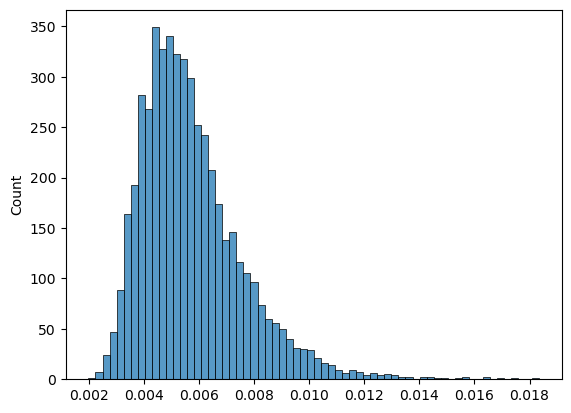

In [15]:
beta_samples = bm_normal.mcmc_samples["beta"]
aux_samples = bm_normal.mcmc_samples["aux_params"][0]

import seaborn as sns
sns.histplot(aux_samples)

Because of the modular design, we can impose arbitrary priors. Here's regularization towards 1 and 10.

In [16]:

laplace_prior1 =distributions.Independent(distributions.Laplace(jnp.ones(8),(jnp.ones(8) )),1)
normal_prior1 = distributions.MultivariateNormalDiag(jnp.ones((8)), jnp.ones(8) )


laplace_prior10 =distributions.Independent(distributions.Laplace(jnp.ones(8)*10,(jnp.ones(8) )),1)
normal_prior10 = distributions.MultivariateNormalDiag(jnp.ones((8))*10, jnp.ones(8) )


bm_normal = sj.BayesGLM(sj.glm.identity_link, distributions.Poisson, normal_prior1, ).fit(X,y)
bm_laplace = sj.BayesGLM(sj.glm.identity_link, distributions.Poisson, laplace_prior1, ).fit(X,y)

bm_normal_10 = sj.BayesGLM(sj.glm.identity_link, distributions.Poisson, normal_prior10, ).fit(X,y)
bm_laplace_10 = sj.BayesGLM(sj.glm.identity_link, distributions.Poisson, laplace_prior10, ).fit(X,y)

bayes_table2 = sj.RegressionTable([bm_normal, bm_laplace, bm_normal_10, bm_laplace_10])
bayes_table2.custom_columns(["Normal(1,1)-Poisson", "Laplace(1,1)-Poisson","Normal(10,1)-Poisson", "Laplace(10,1)-Poisson"])
display(bayes_table2)

Finally, 95% credible intervals for $\beta$ drawn from the MCMC posterior are pre-computed for convenience.

In [17]:
bm_normal.ci

Array([[-9.29888595e-01, -5.75009712e-03, -9.33199511e-01,
        -5.78936255e-02, -7.09097804e-01, -1.58410368e-03,
        -5.68336735e-01, -5.44568029e-03],
       [ 3.00618932e+00,  1.42615280e-01,  2.48536094e+00,
         6.31231850e-01,  2.21597362e-01,  1.90954729e-03,
         2.67226057e+00,  1.04320450e-03]], dtype=float64)

## Elastic-Net GLMs

Elastic net regularization following Glmnet is available for all GLMs, including custom models. The objective for each step, closely following [Tay et al. 2023](https://arxiv.org/pdf/2103.03475), is 

$$
\argmin_{\beta} \left[ (\mathbf z^{(t)} - \mathbf X \beta )^\top \mathbf W^{(t)}  (\mathbf z^{(t)} - \mathbf X \beta )^\top + n\left((1-\alpha)\beta^\top \beta + 2 \alpha ||\beta||_1^1\right)\right]
$$

The model is still fit via IRLS. 
Statjax departs from the paper by regularizing the intercept and not varying $\lambda$. This is to maintain consistency with Glmnet. By default, $\alpha = .5$. Here, we use large values of $\lambda$ to compensate for the small magnitude of $\beta$ given an inverse link. 

In [18]:
lam = .01 
enet_gamma = GammaGLM( lam=1000.).fit(X, y)
lasso_gamma = GammaGLM( lam=1000., alpha=1.).fit(X, y)
ridge_gamma = GammaGLM( lam=1000., alpha=0.).fit(X, y)
regularized_table = sj.RegressionTable([enet_gamma, ridge_gamma, lasso_gamma, ])
regularized_table.custom_columns(["Elastic", "Ridge", "Lasso"])
regularized_table.title("Regularized Gamma GLMs")
display(regularized_table)

# Causal Models

Statjax currently offers four causal ate estimators. We'll first download the Lalonde dataset. 

In [19]:
import pandas as pd
# https://users.nber.org/~rdehejia/nswdata2.html

columns = ["training",   # Treatment assignment indicator
           "age",        # Age of participant
           "education",  # Years of education
           "black",      # Indicate whether individual is black
           "hispanic",   # Indicate whether individual is hispanic
           "married",    # Indicate whether individual is married
           "no_degree",  # Indicate if individual has no high-school diploma
           "re74",       # Real earnings in 1974, prior to study participation
           "re75",       # Real earnings in 1975, prior to study participation
           "re78"]       # Real earnings in 1978, after study end


file_names = ["http://www.nber.org/~rdehejia/data/nswre74_treated.txt",
              "http://www.nber.org/~rdehejia/data/nswre74_control.txt",
              "http://www.nber.org/~rdehejia/data/psid_controls.txt",
              "http://www.nber.org/~rdehejia/data/psid2_controls.txt",
              "http://www.nber.org/~rdehejia/data/psid3_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps2_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps3_controls.txt"]
files = [pd.read_csv(file_name, sep='\s+', header=None, names=columns) for file_name in file_names]
lalonde = pd.concat(files, ignore_index=True)


<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/var/folders/kq/xxx341651fg6vk0b96q6j7r00000gn/T/ipykernel_81470/1230381039.py:24: SyntaxWarning: invalid escape sequence '\s'
  files = [pd.read_csv(file_name, sep='\s+', header=None, names=columns) for file_name in file_names]


`statjax` follows the Rudin causal model, with $D$ indicating treatment status, $X$ indicating covariates, and $Y$ indicating outcomes. We remove points with features outside the range of that feature among the treated points:

In [20]:
from statjax import causal

D = lalonde[["training"]]
X = lalonde[["age", "education", "black", "hispanic", "married", "no_degree", "re74", "re75"]]
Y = lalonde[["re78"]]

in_overlap = causal.check_overlap(D,lalonde[list(X.columns)])

print(f"n violating overlap: {sum(~in_overlap)}")
D = D[in_overlap]
X = X[in_overlap]
Y = Y[in_overlap]

n violating overlap: 7407


The ExperimentalEstimator class assumes random assignment, and simply compares the group means. 

In [21]:
linreg = sj.OLS().fit(D,Y)

linreg_controlled = sj.OLS().fit(jnp.hstack([X.values, D.values]),Y)
print(f"ols coef on treatment w/o controls: {linreg.beta[1]}")
print(f"ols coef on treatment w/ controls: {linreg_controlled.beta[1]}")

naive_model = causal.ExperimentalEstimator().fit(D,Y)
exp_est = naive_model.ate
print(f"naive ate: {exp_est}")

ols coef on treatment w/o controls: -6497.048111659362
ols coef on treatment w/ controls: -107.5805714583357
naive ate: -6497.048111659312


The RegressionEstimator fits two regression models, one for each treatment outcome, and compares the difference in expectation. It defaults to linear estimators. 

In [22]:
regression_model = causal.RegressionEstimator().fit(D,X, Y)
print(f"ols imputation ate: {regression_model.ate}")

ols imputation ate: -2809.6824574998304


It allows for more other regression models. While it takes longer to train, here we use the NNRegression model, which is a flexible neural net that can be used as a miscellaneous non-parametric model. 

In [23]:
from statjax.nn import NNRegression

nn_regression_model =  causal.RegressionEstimator(model=NNRegression(hidden_layers = (128,64)))
nn_regression_model.fit(D,X,Y)
print(f"neural imputation ate: {nn_regression_model.ate}")

neural imputation ate: -6818.2196256187635


The PropensityScoreEstimator fits $p(D_i=1|X_i)$  then uses that as inverse weights. The default model is a logistic regression, but the user can specify alternatives.

Note that the model automatically prunes points with $p>1-\delta$ or $p<\delta$, with the default at initialization as $\delta = .1$. 

In [24]:
from jax.nn import sigmoid

logit_model = causal.PropensityScoreEstimator().fit(D,X,Y)
probit_model = causal.PropensityScoreEstimator(propensity_model=BernoulliGLM(link=sj.glm.probit_link)).fit(D,X,Y)

nn_ps_model = causal.PropensityScoreEstimator(propensity_model=NNRegression(hidden_layers = (32,32),output_activation=sigmoid)).fit(D,X,Y)

print(f"logit ate: {logit_model.ate}, probit ate: {probit_model.ate}, nn ate: {nn_ps_model.ate}")

logit ate: 2186.5376403319, probit ate: 2571.334587733147, nn ate: 1320.169593785673


The propensities can be analyzed:

In [25]:
jnp.percentile(nn_ps_model.propensities, jnp.array([0,25,50,75,100]))

Array([1.13891559e-70, 4.75170118e-30, 1.74601157e-14, 2.26063828e-05,
       3.66121309e-01], dtype=float64)

Finally, `statjax` contains a doubly robust estimator, which can take a custom propensity_model and outcome_model. To demonstrate why pruning is important, we can fit a DRE without any pruning ($\delta = 0$) to see the effect on the ATE.  

As above, the bulk of the runtime is the outcome network. 

In [26]:
dre_model = causal.DREstimator().fit(D,X,Y)
dre_model_unpruned = causal.DREstimator(delta = 0.).fit(D,X,Y)

neural_dre = causal.DREstimator(propensity_model=NNRegression(hidden_layers = (32,32),output_activation=sigmoid)).fit(D,X,Y)
fully_neural_dre = causal.DREstimator(outcome_model=NNRegression(hidden_layers=(128, 128, 64, 64)),
                              propensity_model=NNRegression(hidden_layers = (32,32),output_activation=sigmoid),
                              ).fit(D,X,Y)

print(f"dre ate: {dre_model.ate}\nneural propensity dre ate: {neural_dre.ate}\nfully neural dre ate: {fully_neural_dre.ate}\nunpruned dre ate: {dre_model_unpruned.ate}")

dre ate: 2084.2915877457867
neural propensity dre ate: 1137.4334587308522
fully neural dre ate: 2421.439895598937
unpruned dre ate: 12719550904.208557


The submodels of any causal model can be accessed at model0/model1 for regression-based models and propensity_model for propensity scoring models. Here are all 3 from the DRE:

In [27]:
dre_table = sj.RegressionTable([dre_model.propensity_model, dre_model.model0, dre_model.model1])
dre_table.custom_columns(["P(D=1|X)", "E[Y|X,D=0]", "E[Y|X,D=1]"])
dre_table